### imports:

In [9]:
import os
import torchaudio
from torch.utils.data import Dataset
import random
import torch
import torchaudio.transforms as T
import noisereduce as nr
from tqdm import tqdm
import numpy as np
import scipy.signal
import librosa
import matplotlib.pyplot as plt

### DATASET CLASS:

In [35]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, task="gender", transform=None, feature_extractor=None, n_persons=None, seed=42, 
                 use_preprocessed=False, preprocessed_dir="preprocessed",
                 features_to_extract=None, segment_length=None, segment_overlap=None, **feature_params):
        """
        Args:
            root_dir (str): Path to the directory containing the audio files.
            task (str): The task to perform. Options are "gender" or "owner".
            transform (callable, optional): Optional transform to be applied on a sample.
            feature_extractor (callable, optional): Function to extract features from the waveform.
            n_persons (int, optional): Number of unique persons (studentIDs) to include for owner classification.
            seed (int, optional): Seed for reproducibility when selecting N persons.
            use_preprocessed (bool, optional): Whether to use preprocessed data if available.
            preprocessed_dir (str, optional): Directory containing preprocessed features.
        """
        self.root_dir = root_dir
        self.task = task
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.n_persons = n_persons
        self.seed = seed
        self.use_preprocessed = use_preprocessed
        self.preprocessed_dir = preprocessed_dir
        self.features_to_extract = features_to_extract or []
        self.segment_length = segment_length
        self.segment_overlap = segment_overlap
        self.feature_params = feature_params

        self.data = []
        self.student_ids = set()

        # Load and parse filenames
        for file in os.listdir(root_dir):
            if file.endswith(".mp3"):
                parts = file[:-4].split("_")  # Remove .mp3 and split by _

                # Validate file naming format
                if len(parts) == 4 and parts[0].startswith("HW") and \
                   (parts[1] == "intro" or parts[1].startswith("Q")) and \
                   parts[3] in ["male", "female"]:

                    try:
                        homework_number = int(parts[0][2:])
                        question_number = None if parts[1] == "intro" else int(parts[1][1:])
                        student_id = parts[2]
                        gender = parts[3]

                        self.data.append({
                            "file_path": os.path.join(root_dir, file),
                            "homework_number": homework_number,
                            "question_number": question_number,
                            "student_id": student_id,
                            "gender": gender
                        })

                        self.student_ids.add(student_id)
                    except ValueError:
                        # Skip files with invalid formats
                        continue

        if task == "owner" and n_persons is not None:
            random.seed(seed)
            selected_ids = random.sample(self.student_ids, n_persons)
            self.data = [item for item in self.data if item["student_id"] in selected_ids]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.use_preprocessed and self.preprocessed_dir:
            preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
            if os.path.exists(preprocessed_path):
                return torchaudio.load(preprocessed_path)

        file_path = sample["file_path"]

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)

        # Resample to a consistent rate
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
            waveform = resampler(waveform)
            sample_rate = target_sample_rate

        # Apply noise reduction
        waveform = nr.reduce_noise(y=waveform.numpy(), sr=sample_rate)
        waveform = torch.tensor(waveform)

        # Normalize waveform
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)

        # Apply transform if specified
        if self.transform:
            waveform = self.transform(waveform)

        # Extract features if feature_extractor is specified
        if self.feature_extractor:
            features = self.feature_extractor(waveform, sample_rate)
        else:
            features = waveform

        if self.task == "gender":
            label = 0 if sample["gender"] == "male" else 1
        elif self.task == "owner":
            label = sample["student_id"]
        else:
            raise ValueError("Unsupported task. Use 'gender' or 'owner'.")

        return {
            "features": features,
            "sample_rate": sample_rate,
            "label": label,
            "metadata": sample
        }
    
    def wiener_filter(self, noisy_signal, sr, mysize=29, noise_std=0.5):
        return scipy.signal.wiener(noisy_signal, mysize=mysize, noise=noise_std)

    def preprocess_and_save(self):
        """
        Preprocess and save features to disk as MP3 files to avoid reloading and reprocessing large datasets.
        """
        os.makedirs(self.preprocessed_dir, exist_ok=True)
        for sample in tqdm(self.data, desc="Processing Audio Files"):
            file_path = sample["file_path"]
            waveform, sample_rate = torchaudio.load(file_path)

            # Resample to a consistent rate
            target_sample_rate = 44100
            if sample_rate != target_sample_rate:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
                waveform = resampler(waveform)
                sample_rate = target_sample_rate

            # # Apply noise reduction

            # # Normalize waveform
            waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)
            
            waveform = self.wiener_filter(noisy_signal=waveform.numpy(), sr=target_sample_rate)
            waveform = torch.tensor(waveform)
            # Convert to Pydub AudioSegment for MP3 saving

            # Save preprocessed audio as MP3
            save_path = os.path.join(self.preprocessed_dir, os.path.basename(file_path))
            torchaudio.save(save_path, waveform, target_sample_rate)
            
    def plot_audio_lengths(self):
        lengths = []
        for sample in tqdm(self.data, desc="Processing Audio Files"):
            file_path = sample["file_path"]
            waveform, sample_rate = torchaudio.load(file_path)
            length = waveform.size(1) / sample_rate
            lengths.append(length)

        plt.figure(figsize=(18, 9))
        plt.hist(lengths, bins=100, edgecolor='black')
        plt.xlabel('Length (seconds)')
        plt.ylabel('Number of Files')
        plt.title('Histogram of Audio File Lengths')
        plt.show()
        
        min_length = min(lengths)
        print(f"Minimum audio length: {min_length:.2f} seconds")
        



In [39]:
import torch

# Clear GPU memory
torch.cuda.empty_cache()

# To check reserved memory
print(torch.cuda.memory_reserved())

# To check allocated memory
print(torch.cuda.memory_allocated())


0
0


: 

In [36]:
myData = AudioDataset("../../HW1_M", preprocessed_dir="../../preprocessed")

In [37]:
myData.preprocess_and_save()

Processing Audio Files:  14%|█▍        | 97/676 [18:27<1:50:08, 11.41s/it]


MemoryError: Unable to allocate 7.82 GiB for an array with shape (30, 34992000) and data type float64

Processing Audio Files: 100%|██████████| 676/676 [06:31<00:00,  1.73it/s]


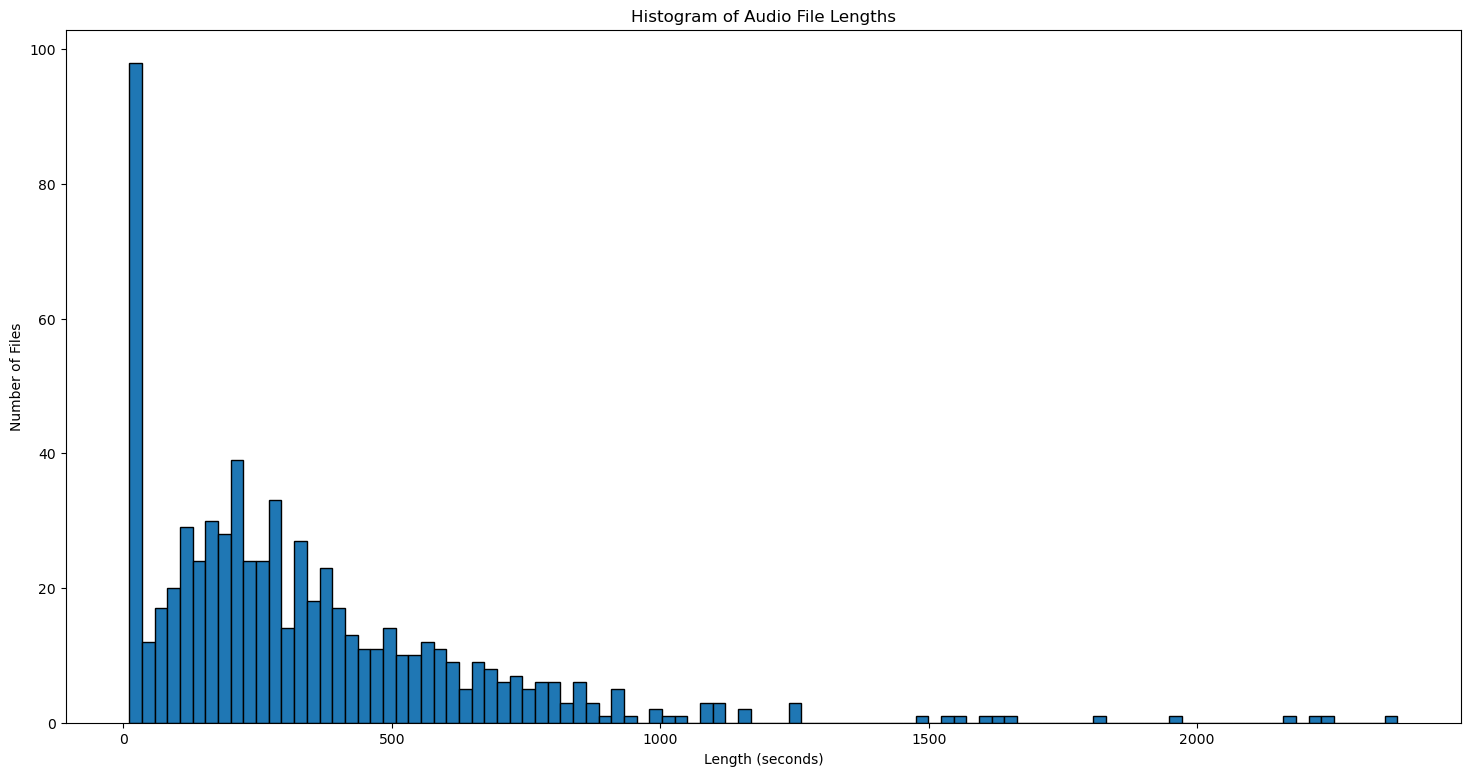

Minimum audio length: 10.87 seconds


In [21]:
myData.plot_audio_lengths()